# LN - Data PP - Graph definition 

## Libraries, data and directory

In [81]:
import sqlite3
import numpy as np
import pandas as pd
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import time
import random
import pickle
import deepdish as dd
import dask.array as da
import sys
from datetime import datetime
import os

from tqdm.notebook import trange, tqdm
from time import sleep



In [95]:
directory='/Users/dsrincon/Dropbox/Personal/EDU/Posgrado/masters_usa/MIMS/research/MIMS_capstone'

In [4]:
# Create your connection.
cnx = sqlite3.connect(directory+'/data/LN_channels.db')
df = pd.read_sql_query("SELECT * FROM channels", cnx)


In [5]:
df['dec_id']=df.index # Add column with decission id
df.head()

,short_channel_id,open_block,open_transaction,address,close_block,close_transaction,node0,node1,satoshis,last_seen,open_time,open_fee,close_time,close_fee,last_update,close_type,close_htlc_count,close_balance_a,close_balance_b,dec_id
0,505149x622x0,505149,f6bc767df9148ebf76d2b9baf4eb46e3230712c2bf5a51...,bc1qjmg6ev344fenh3zhg0yjl6hyvxpxluw6x9nn2a5lv4...,592638.0,82cb2ea2a06c8c453d8b9ca08e17bbefe87225aa380b2d...,0250373555232cec757ea141273e75381c84cc3ab22f1e...,02ef61a252f9504a42fc264a28476f44cea0711a44b2da...,300000,2019-08-22 02:49:00,1516441417,40748,1.567276e+09,184.0,1.563172e+09,mutual,0.0,3570.0,296246.0,0
1,513675x2245x0,513675,4297b5fe9beeb701c67fd0f84861b22edbcafe5c25be67...,bc1qymmdt0vzhdjqyqw2cevrqppp6rrlg5j2l20yk72z6y...,594718.0,3f86d9427c750f37a963b5a329da8941520f5a6cdbfe02...,028aa5a991a2acf33da91674fe062219b640e5e57d77a4...,03fab7f8655169ea77d9691d4bd359e97782cb6177a6f7...,50000,2019-10-07 02:42:58,1521144238,306,1.568401e+09,4410.0,1.552879e+09,unused,0.0,45590.0,0.0,1
2,513887x1177x0,513887,3b4cc434e62c1739e79171c7c1641bf9ac0e32d8530c68...,bc1q48l3h7sfdjaqat3sy98naltkwlujwefwnkfqxfm8fd...,NaN,None,02d97e94cfeedca2a3da47acb400bc6836e671b3cb3fc0...,03fab7f8655169ea77d9691d4bd359e97782cb6177a6f7...,50000,2020-02-14 03:15:22,1521262476,442,NaN,NaN,1.581536e+09,None,NaN,NaN,NaN,2
3,513909x1248x0,513909,86311514680351b1e644276efd7704ba13be169cc1a272...,bc1q24kvd9wdjdhwgr54fmu7cu9xldmsjuwdsq2ph5fwnj...,NaN,None,02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f...,03fab7f8655169ea77d9691d4bd359e97782cb6177a6f7...,20000,2020-02-14 03:15:26,1521271023,306,NaN,NaN,1.581464e+09,None,NaN,NaN,NaN,3
4,513910x1814x1,513910,7f010765ce336d2be78c846844544e6a06ce2c59e7785f...,bc1qzh9xrpqvyse7fuanc8tl5e75qymq5fzk3deh78hs02...,NaN,None,02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f...,03fab7f8655169ea77d9691d4bd359e97782cb6177a6f7...,20000,2020-02-14 03:15:26,1521272338,153,NaN,NaN,1.581466e+09,None,NaN,NaN,NaN,4


## Extract decisions per blocks

### Create blocks and nodes

In [6]:
# Generate block array with blocks where decisions have taken place. 

# Find blocks where opening decisions have taken place
blocks_open=df.open_block.to_numpy()
blocks_open=np.unique(blocks_open)

# Find blocks where closing deciscions have taken place
blocks_close=df.close_block.to_numpy()
blocks_close=np.nan_to_num(blocks_close)
blocks_close=np.unique(blocks_close)


# Union of blocks with opening and closing decisions
blocks=set(blocks_open).union(blocks_close)
blocks=list(blocks)
blocks=np.sort(np.array(blocks))
blocks=blocks[1:] # N/A will create a block 0 that needs to be removed
blocks=blocks.astype(int)


print('Total blocks with decisions: {}'.format(len(blocks)))

Total blocks with decisions: 36543


In [16]:
# Extract unique nodes, create smaller ids 

# Unique nodes
nodes=set(df.node0).union(set(df.node1))
nodes=list(nodes)

# Create ids and dictionary that relates ids to nodes 
ids=np.arange(len(nodes))
nodes_id={nodes:i for i,nodes in zip(ids,nodes)} # Create dictionary with_node_ids

# Create columns with node ids
df['node0_id']=df['node0']
df['node1_id']=df['node1']
df.replace({'node0_id':nodes_id,'node1_id':nodes_id},inplace=True)

print('Total nodes: {}'.format(len(nodes)))
df.head()

Total nodes: 7735


,short_channel_id,open_block,open_transaction,address,close_block,close_transaction,node0,node1,satoshis,last_seen,...,close_time,close_fee,last_update,close_type,close_htlc_count,close_balance_a,close_balance_b,dec_id,node0_id,node1_id
0,505149x622x0,505149,f6bc767df9148ebf76d2b9baf4eb46e3230712c2bf5a51...,bc1qjmg6ev344fenh3zhg0yjl6hyvxpxluw6x9nn2a5lv4...,592638.0,82cb2ea2a06c8c453d8b9ca08e17bbefe87225aa380b2d...,0250373555232cec757ea141273e75381c84cc3ab22f1e...,02ef61a252f9504a42fc264a28476f44cea0711a44b2da...,300000,2019-08-22 02:49:00,...,1.567276e+09,184.0,1.563172e+09,mutual,0.0,3570.0,296246.0,0,3098,1492
1,513675x2245x0,513675,4297b5fe9beeb701c67fd0f84861b22edbcafe5c25be67...,bc1qymmdt0vzhdjqyqw2cevrqppp6rrlg5j2l20yk72z6y...,594718.0,3f86d9427c750f37a963b5a329da8941520f5a6cdbfe02...,028aa5a991a2acf33da91674fe062219b640e5e57d77a4...,03fab7f8655169ea77d9691d4bd359e97782cb6177a6f7...,50000,2019-10-07 02:42:58,...,1.568401e+09,4410.0,1.552879e+09,unused,0.0,45590.0,0.0,1,5474,7365
2,513887x1177x0,513887,3b4cc434e62c1739e79171c7c1641bf9ac0e32d8530c68...,bc1q48l3h7sfdjaqat3sy98naltkwlujwefwnkfqxfm8fd...,NaN,None,02d97e94cfeedca2a3da47acb400bc6836e671b3cb3fc0...,03fab7f8655169ea77d9691d4bd359e97782cb6177a6f7...,50000,2020-02-14 03:15:22,...,NaN,NaN,1.581536e+09,None,NaN,NaN,NaN,2,2797,7365
3,513909x1248x0,513909,86311514680351b1e644276efd7704ba13be169cc1a272...,bc1q24kvd9wdjdhwgr54fmu7cu9xldmsjuwdsq2ph5fwnj...,NaN,None,02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f...,03fab7f8655169ea77d9691d4bd359e97782cb6177a6f7...,20000,2020-02-14 03:15:26,...,NaN,NaN,1.581464e+09,None,NaN,NaN,NaN,3,211,7365
4,513910x1814x1,513910,7f010765ce336d2be78c846844544e6a06ce2c59e7785f...,bc1qzh9xrpqvyse7fuanc8tl5e75qymq5fzk3deh78hs02...,NaN,None,02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f...,03fab7f8655169ea77d9691d4bd359e97782cb6177a6f7...,20000,2020-02-14 03:15:26,...,NaN,NaN,1.581466e+09,None,NaN,NaN,NaN,4,211,7365


### TODO: Deal with multiple channels between nodes

### Extract channel openings

In [124]:
# Generate dictionary of channel openings
channel_opens={}
for b in blocks:
    channel_array=df[df['open_block']==b][['node0_id','node1_id','satoshis','open_fee','dec_id','short_channel_id']].to_numpy()
    list_channels=[(channel[0],channel[1],{'capacity':channel[2],'open_fee':channel[3],'dec_id':channel[4],'channel_id':channel[5]}) for channel in channel_array]
    channel_opens[b]=list_channels
    


In [131]:
# TESTING: Channel openings
## sum of openings should be equivalent to openings from Data Frame

total_opens=len(df['open_block'])
saved_opens=np.sum(np.array([len(opens) for opens in list(channel_opens.values()) ]))
only_open_dic={b:opens for b,opens in channel_opens.items() if len(opens)>0}
                
print('Total opens:{} '.format(total_opens))
print('Registered opens: {}'.format(saved_opens))

rand_block=random.choice(list(only_open_dic.keys()))
print("Data Sample for 'channel_opens dictionary for block {}'".format(rand_block))
print(channel_opens[rand_block])

Total opens:72476 
Registered opens: 72476
Data Sample for 'channel_opens dictionary for block 567127'
[(3301, 3256, {'capacity': 100000, 'open_fee': 3747, 'dec_id': 19779, 'channel_id': '567127x653x0'}), (3301, 4270, {'capacity': 100000, 'open_fee': 3747, 'dec_id': 19780, 'channel_id': '567127x654x0'})]


In [126]:
# SAVE: Channel openings to disk

with open(directory+'/data/channel_opens.p', 'wb') as fp:
    pickle.dump(channel_opens, fp, protocol=pickle.HIGHEST_PROTOCOL)

### Extract channel closures

In [127]:
# Generate dictionary of channel closures
channel_closures={}
for b in blocks:
    channel_array=df[df['close_block']==b][['node0_id','node1_id','close_type','dec_id','short_channel_id']].to_numpy()
    list_channels=[(channel[0],channel[1],{'close_type':channel[2],'dec_id':channel[3],'channel_id':channel[4]}) for channel in channel_array]
    channel_closures[b]=list_channels



In [128]:
# TESTING: Channel closures
total_closes=len(df[pd.notna(df['close_block'])])

saved_closes=np.sum(np.array([len(closes) for closes in list(channel_closures.values()) ]))
only_close_dic={b:closes for b,closes in channel_closures.items() if len(closes)>0}
                
print('Total closes:{} '.format(total_closes))
print('Registered closes: {}'.format(saved_closes))

rand_block=random.choice(list(only_close_dic.keys()))
print("Data Sample for 'channel_closures dictionary for block {}'".format(rand_block))
print(channel_closures[rand_block])

Total closes:38355 
Registered closes: 38355
Data Sample for 'channel_closures dictionary for block 580008'
[(7104, 7558, {'close_type': 'force', 'dec_id': 15520, 'channel_id': '565055x2420x0'})]


In [129]:
# SAVE: Channel closures to disk
#dd.io.save(directory+'/data/channel_closures.h5',channel_closures)

with open(directory+'/data/channel_closures.p', 'wb') as fp:
    pickle.dump(channel_closures, fp, protocol=pickle.HIGHEST_PROTOCOL)

### Create Graph snapshots (per block)

**TODO: Rewrite using dask arrays to avoid bloating memory**

In [119]:
# Create sequential snapshots of graph

#graph_snapshots={} # Initialize dic where graphs for each block will be stored

graph_snapshots=[]
snapshot_i=[]
now = datetime.now()
timestamp = int(datetime.timestamp(now))
save_dir=directory+'/data/graph_snapshots/'+str(timestamp)
os.mkdir(save_dir)


# Raw snapshots generated by adding opens and removing closures (not selecting connected components yet)

G=nx.Graph()

snapshot_nodes=[]
snapshot_edges=[]
snapshot_connectivity=[]


snapshots=4000
#snapshots=len(blocks) #- UNCOMMENT for full processing


with tqdm(total=len(range(snapshots))) as pbar:
    for i in range(snapshots):
        snapshot_i=[]
        
        G.graph['block']=blocks[i]
        # Add new edges
        
        G.add_edges_from(channel_opens[blocks[i]])

        # Remove edges
        ## Create temp list of closures that removes metadata to remove from graph
        closure_pairs=[(closure[0],closure[1]) for closure in channel_closures[blocks[i]]]
        G.remove_edges_from(closure_pairs)
       
        
        # Save Graph to disk
        nx.write_gpickle(G, save_dir+'/'+str(blocks[i])+'.gpickle')
        
    
        
        snapshot_nodes.append(len(G))
        snapshot_edges.append(len(list(G.edges)))
        snapshot_connectivity.append(nx.algorithms.components.is_connected(G))
        
        pbar.update(1) # Update progress bar


In [120]:
# Extract connected components

connected_size_snapshots=[] # Initialize array to store what percentage of total graph is the connected component

#save_dir=directory+'/data/graph_snapshots/'+1585332889' # Overwrite save_dir to change specific files
snapshot_nodes=[]
snapshot_edges=[]
snapshot_connectivity=[]

new_dir=directory+'/data/graph_snapshots/'+str(timestamp)+'_connected'
os.mkdir(new_dir)

with tqdm(total=len(os.listdir(save_dir))) as pbar:
    
    for filename in sorted(os.listdir(save_dir)):
        G = nx.read_gpickle(save_dir+'/'+filename)
   # for b,G in graph_snapshots:
        connected_components=nx.algorithms.components.connected_components(G)
        
        connected_components=[c for c in nx.algorithms.components.connected_components(G)]
        G_connected=G.subgraph(connected_components[0]).copy()
        
        #G_connected=G.subgraph(connected_components[0])
        largest_component_ratio=len(G_connected)/len(G)
        connected_size_snapshots.append(largest_component_ratio)
        
        snapshot_nodes.append(len(G_connected))
        snapshot_edges.append(len(list(G_connected.edges)))
        snapshot_connectivity.append(nx.algorithms.components.is_connected(G_connected))
                              
        nx.write_gpickle(G_connected,new_dir+'/'+filename)
        
        #graph_snapshots[b]=G_connected
        
        pbar.update(1)
        


## Test and Save to disk

4000 blocks analyzed (min:505149, max553619):
Average connectivity of blocks: 1.0
Average ratio of connected component:0.8127937888441474


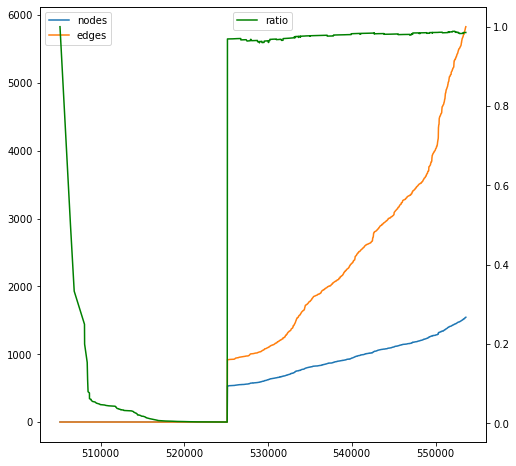

In [121]:
# Test that graph snapshots have been been correctly created 

# Number of blocks extracted, min and max block
blocks_analyzed=np.array(blocks[:snapshots])
max_block=np.max(blocks_analyzed)
min_block=np.min(blocks_analyzed)
no_blocks=len(blocks_analyzed)

# Graph characteristics


# Test attributes

mean_snapshot_ratio=np.mean(np.array(connected_size_snapshots))
#snapshot_connectivity=[int(nx.algorithms.components.is_connected(graph_snapshots[k])) for k in sorted(graph_snapshots.keys())]
mean_connectivity=np.mean(np.array(snapshot_connectivity))


# Results
print('{} blocks analyzed (min:{}, max{}):'.format(no_blocks,min_block,max_block))
print('Average connectivity of blocks: {}'.format(mean_connectivity))
print('Average ratio of connected component:{}'.format(mean_snapshot_ratio))

# Visualize evolutio of size

fig,ax1=plt.subplots(figsize=(8,8))
ax1.plot(blocks_analyzed, snapshot_nodes)
ax1.plot(blocks_analyzed, snapshot_edges)
ax2=ax1.twinx()
ax1.legend(['nodes', 'edges'], loc='upper left')
ax2.plot(blocks_analyzed, connected_size_snapshots,color='green')
ax2.legend(['ratio'], loc='upper center')

#plt.show()

In [122]:
# SAVE: DF as CSV
df.to_csv(directory+'/data/LN_channels.csv', index = False)